# 대충 RNN 짜는 코드

> writer : nemo<br>
> 2020-08-04

## Contents
이 글에서는 [TensorFlow - 순환 신경망을 활용한 문자열 생성](https://www.tensorflow.org/tutorials/text/text_generation?hl=ko)을 기반으로 numpy를 이용해 RNN 모델을 만들어 실습한 내용을 적고자 한다.

## 1. Data
### 1.1. get Data

In [843]:
!pip install tensorflow-gpu==2.0.0
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

파일을 가져오자

In [833]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

### 1.2. 문자열 벡터화
#### 1.2.1 Decoding from utf-8
파이썬 3과 호환되도록 디코딩하자

In [834]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

텍스트가 어떤 형태인지 살펴보자. 평범(?)한 파이썬 문자열 형태이다.

In [835]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



#### 1.2.2. 문자를 수에 대응하기
텍스트에 존재하는 문자들을 수에 대응시키고 변환과 역변환 딕셔너리를 만들어두자.

In [836]:
vocab = sorted(set(text))
print('고유 문자수 {}개\n'.format(len(vocab)))
c2i = {u:i for i, u in enumerate(vocab)}
i2c = {i:u for u, i in c2i.items()}
print('c2i\n{}\n'.format(c2i))
print('i2c\n{}'.format(i2c))

고유 문자수 65개

c2i
{'\n': 0, ' ': 1, '!': 2, '$': 3, '&': 4, "'": 5, ',': 6, '-': 7, '.': 8, '3': 9, ':': 10, ';': 11, '?': 12, 'A': 13, 'B': 14, 'C': 15, 'D': 16, 'E': 17, 'F': 18, 'G': 19, 'H': 20, 'I': 21, 'J': 22, 'K': 23, 'L': 24, 'M': 25, 'N': 26, 'O': 27, 'P': 28, 'Q': 29, 'R': 30, 'S': 31, 'T': 32, 'U': 33, 'V': 34, 'W': 35, 'X': 36, 'Y': 37, 'Z': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64}

i2c
{0: '\n', 1: ' ', 2: '!', 3: '$', 4: '&', 5: "'", 6: ',', 7: '-', 8: '.', 9: '3', 10: ':', 11: ';', 12: '?', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'E', 18: 'F', 19: 'G', 20: 'H', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'M', 26: 'N', 27: 'O', 28: 'P', 29: 'Q', 30: 'R', 31: 'S', 32: 'T', 33: 'U', 34: 'V', 35: 'W', 36: 'X', 37: 'Y', 38: 'Z', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: '

#### 1.2.3. text를 numpy array로 변환
텍스트를 숫자로 변환하고, 이를 numpy array로 만들자

In [837]:
t2i = [c2i[i] for i in text]
ntext = np.array(t2i)
print(ntext[:20])

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56]


### 1.3. 데이터 전처리

X랑 Y 만들기<br>
X는 문자인 텍스트를 숫자에 대응시킨 것이고, Y는 다음 문자를 나타내는 배열로 X를 옆으로 한 칸 밀어서 만든다.

In [838]:
# 단일 입력에 대해 원하는 문장의 최대 길이
seq_length = 100
examples_per_epoch = len(text) // seq_length

namoji = len(ntext) % (seq_length)
sequences = ntext[:-namoji].reshape((-1, seq_length))
X = sequences
Y = np.ones(sequences.shape, dtype = np.int64)
Y[:,:-1] = sequences[:,1:]
print(X[0])
print(Y[0])

[18 47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43
  1 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43
 39 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49
  6  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10
  0 37 53 59]
[47 56 57 58  1 15 47 58 47 64 43 52 10  0 14 43 44 53 56 43  1 61 43  1
 54 56 53 41 43 43 42  1 39 52 63  1 44 59 56 58 46 43 56  6  1 46 43 39
 56  1 51 43  1 57 54 43 39 49  8  0  0 13 50 50 10  0 31 54 43 39 49  6
  1 57 54 43 39 49  8  0  0 18 47 56 57 58  1 15 47 58 47 64 43 52 10  0
 37 53 59  1]


### 1.4. Train set과 Test Set으로 나누기
배치 개수를 보자

In [881]:
print(X.shape[0])

11153


11000개는 train set로 쓰고 153개는 test set로 쓰자

In [892]:
X_train = X[:11000]
Y_train = Y[:11000]

X_test = X[11000:]
Y_test = Y[11000:]

## 2. RNN

### 2.1. 계획

Xavier Initialization + RNN + softmax + cross-entropy loss

---

### 2.2. Xavier Initialization + RNN

In [944]:
class RNN:

    def __init__(self, x_size, y_size, h_size):

        self.x_size = x_size
        self.y_size = y_size
        self.h_size = h_size

        # Xavier Initialization
        self.Whh = np.random.uniform(size=(h_size, h_size), low=- 1 / np.sqrt(h_size),
                                     high=+ 1 / np.sqrt(h_size)) * 0.001
        self.Wxh = np.random.uniform(size=(x_size, h_size), low=- 1 / np.sqrt(x_size),
                                     high=+ 1 / np.sqrt(x_size)) * 0.001
        self.bh = np.zeros((1, h_size))

        self.Why = np.random.uniform(size=(h_size, y_size), low=- 1 / np.sqrt(h_size),
                                     high=+ 1 / np.sqrt(h_size)) * 0.001
        self.by = np.zeros((1, y_size))

        self.h_0 = None

    def f(self, x_size, y_size, h_size, Whh, Wxh, bh, Why, by, h_0):

        self.x_size = x_size
        self.y_size = y_size
        self.h_size = h_size
        self.Whh = Whh
        self.Wxh = Wxh
        self.bh = bh
        self.Why = Why
        self.by = by
        self.h_0 = h_0

    def forward_t(self, x_t, h_t_bef):

        # x_t : [N, x_size]
        # h_t_bef : [N, h_size]

        h_t = np.tanh(h_t_bef.dot(self.Whh) + x_t.dot(self.Wxh) + self.bh)  # (N, h)
        y_t = h_t.dot(self.Why) + self.by  # [N, y_size]

        return y_t, h_t  # [N, hidden]

    def forward(self, X, h_0=None):

        X = X.T
        time = X.shape[0]
        N = X.shape[1]

        # X : [time, N]
        # X_one_hot_encoding [time, N] => [time, N, character_개수]

        self.X_one_hot_encoding = np.zeros((time, N, self.x_size))
        self.X_one_hot_encoding[np.arange(time * N) // N, np.arange(time * N) % N, X.reshape(-1)] = 1

        if self.h_0 is None:
            self.h_0 = np.zeros(self.h_size)

        h_0 = np.array(self.h_0.tolist() * N).T.reshape(N, -1)

        y_cache = None
        h_cache = np.array([h_0])  # [t, N, h_size]

        for x_t in self.X_one_hot_encoding:

            y_t, h_t = self.forward_t(x_t, h_cache[-1])
            if y_cache is None:
                y_cache = np.array([y_t])
            else:
                y_cache = np.append(y_cache, [y_t], axis=0)
            h_cache = np.append(h_cache, [h_t], axis=0)

        return y_cache, h_cache

    def backward_t(self, x_t, h_t, h_bef, dy_t, dh_t):  # [N, y_size] 글자 단위 backward

        # x_t : [N, x_size]
        # h_t : [N, h_size]
        # h_bef : [N, h_size]
        # y_t : [N, y_size]
        # dy_t : [N, y_size]
        # dh_t : [N, h_size]

        dWhy = h_t.T.dot(dy_t)
        dby = dy_t.sum(axis=0)
        dh_t += dy_t.dot(self.Why.T)

        dWhh = dh_t.sum(axis=0) * h_bef.T.dot(1 - h_t ** 2)
        dWxh = dh_t.sum(axis=0) * x_t.T.dot(1 - h_t ** 2)
        dh_bef = dh_t * (1 - h_t ** 2).dot(self.Whh.T)
        dbh = dh_t.sum(axis=0) * (1 - h_t ** 2).sum(axis=0)

        return dWhh, dWxh, dbh, dWhy, dby, dh_bef

    def backward(self, dy, y_cache, h_cache):

        dy = np.flip(dy, axis=0)
        y_cache = np.flip(y_cache, axis=0)
        h_cache = np.flip(h_cache, axis=0)

        # dy : [time(t ~ 1), N, y_size]
        # y_cache : [time(t ~ 1), N, y_size]
        # h_cahce : [time(t ~ 0), N, h_size]

        dWhh = np.zeros_like(self.Whh)
        dWxh = np.zeros_like(self.Wxh)
        dbh = np.zeros_like(self.bh)
        dWhy = np.zeros_like(self.Why)
        dby = np.zeros_like(self.by)
        dh_t = np.zeros((h_cache.shape[1], h_cache.shape[2]))

        for x_t in np.flip(self.X_one_hot_encoding, axis=0):
            dWhh_t, dWxh_t, dbh_t, dWhy_t, dby_t, dh_t = self.backward_t(x_t, h_cache[0], h_cache[1], dy[0], dh_t)

            # Update
            dWhh += dWhh_t
            dWxh += dWxh_t
            dbh += dbh_t
            dWhy += dWhy_t
            dby += dby_t

            # stack pop
            dy = np.delete(dy, (0), axis=0)
            y_cache = np.delete(y_cache, (0), axis=0)
            h_cache = np.delete(h_cache, (0), axis=0)

        dh_0 = dh_t

        return dWhh, dWxh, dbh, dWhy, dby, dh_0

    def gra_update(self, dWhh, dWxh, dbh, dWhy, dby, dh_0):

        np.clip(dWhh, -5, 5, out=dWhh)
        np.clip(dWxh, -5, 5, out=dWxh)
        np.clip(dbh, -5, 5, out=dbh)
        np.clip(dWhy, -5, 5, out=dWhy)
        np.clip(dby, -5, 5, out=dby)
        np.clip(dh_0, -5, 5, out=dh_0)

        self.Whh -= dWhh * 0.001
        self.Wxh -= dWxh * 0.001
        self.bh -= dbh * 0.001
        self.Why -= dWhy * 0.001
        self.by -= dby * 0.001
        self.h_0 -= dh_0.sum(axis=0) * 0.001

    def generator(self, X, length):

        X = X.T
        time = X.shape[0]
        N = X.shape[1]

        # X : [time, N]
        # X_one_hot_encoding [time, N] => [time, N, character_개수]

        self.X_one_hot_encoding = np.zeros((time, N, self.x_size))
        self.X_one_hot_encoding[np.arange(time * N) // N, np.arange(time * N) % N, X.reshape(-1)] = 1

        if self.h_0 is None:
            self.h_0 = np.zeros(self.h_size)

        h_0 = np.array(self.h_0.tolist() * N).T.reshape(N, -1)

        y_cache = None
        h_cache = np.array([h_0])  # [t, N, h_size]

        for x_t in self.X_one_hot_encoding:

            y_t, h_t = self.forward_t(x_t, h_cache[-1])
            if y_cache is None:
                y_cache = np.array([y_t])
            else:
                y_cache = np.append(y_cache, [y_t], axis=0)
            h_cache = np.append(h_cache, [h_t], axis=0)
        
        for x_t in range(length):
            
            y_t, h_t = self.forward_t(y_t[-1], h_cache[-1])
            y_cache = np.append(y_cache, [y_t], axis=0)
            h_cache = np.append(h_cache, [h_t], axis=0)

        return y_cache

In [873]:
class SOFTMAX:
    
    def __init__(self):

        pass
    
    def loss(self, x, y): # from cs231n assignment
        
        probs = np.exp(x - np.max(x, axis=1, keepdims=True))
        probs /= np.sum(probs, axis=1, keepdims=True)
        N = x.shape[0]
        loss = -np.sum(np.log(probs[np.arange(N), y])) / N
        dx = probs.copy()
        dx[np.arange(N), y] -= 1
        dx /= N

        return loss, dx

### 2.2. Small Data에 대한 RNN의 동작 확인

#### 2.2.1. training

In [874]:
rnn_small = RNN(9, 9, 10)
softmax = SOFTMAX()
_X = np.array([[1,2,3,4,5], [2,3,4,5,6], [3,4,5,6,7]])
_Y = np.array([[2,3,4,5,6], [3,4,5,6,7], [4,5,6,7,8]])
history_loss = []

for i in tqdm_notebook(range(100000)):
    y_cache, h_cache = rnn_small.forward(_X[0:3]) # t, N, y

    time = y_cache.shape[0]
    N = y_cache.shape[1]

    y_cache = y_cache.reshape(time * N, -1)
    Real_Y = _Y[0:3].T.reshape(time * N)

    loss, dy = softmax.loss(y_cache, Real_Y)
    
    history_loss.append(loss)

    dy = dy.reshape(time, N, -1)
    y_cache = y_cache.reshape(time, N, -1)

    dWhh, dWxh, dbh, dWhy, dby, dh_0 = rnn_small.backward(dy, y_cache, h_cache)
    rnn_small.gra_update(dWhh, dWxh, dbh, dWhy, dby, dh_0)

/home/tm/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


#### 2.2.2. Show Graph

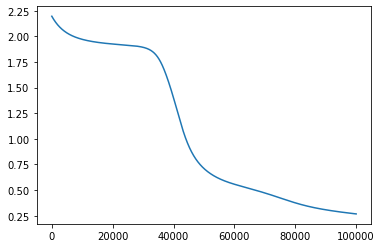

In [875]:
plt.plot(history_loss)
plt.show()

#### 2.2.3. Test
1의 다음 수는 2, 2의 다음 수는 3, 3의 다음 수는 4 ~

In [880]:
y_cache, h_cache = rnn.forward(np.array([[1,2,3,4,5,6,7,8]]))
print(y_cache.argmax(axis=2).reshape(-1))

[2 3 4 5 6 7 8 3]


### 2.3. shakespeare.txt에 적용하기

#### 2.3.1. training

In [888]:
rnn = RNN(65, 65, 30)
softmax = SOFTMAX()
history_loss = []
for j in tqdm_notebook(range(200)):
    for i in range(110):
        y_cache, h_cache = rnn.forward(X_train[0+100*i:100+100*i]) # t, N, y

        time = y_cache.shape[0]
        N = y_cache.shape[1]

        y_cache = y_cache.reshape(time * N, -1)
        Real_Y = Y_train[0+100*i:100+100*i].T.reshape(time * N)

        loss, dy = softmax.loss(y_cache, Real_Y)
        history_loss.append(loss)

        dy = dy.reshape(time, N, -1)
        y_cache = y_cache.reshape(time, N, -1)

        dWhh, dWxh, dbh, dWhy, dby, dh_0 = rnn.backward(dy, y_cache, h_cache)
        rnn.gra_update(dWhh, dWxh, dbh, dWhy, dby, dh_0)

/home/tm/miniconda3/envs/cs231n/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


#### 2.3.2. Show Graph

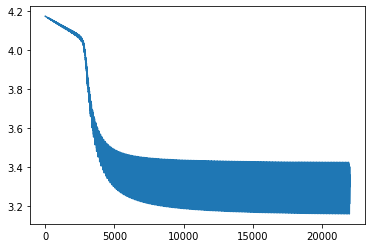

In [908]:
plt.plot(history_loss[:])
plt.show()

#### 2.3.3 test

In [964]:
y_cache, h_cache = rnn.forward(X_test) # t, N, y

time = y_cache.shape[0]
N = y_cache.shape[1]

y_cache = y_cache.reshape(time * N, -1)
Real_Y = Y_test.T.reshape(time * N)
print(np.sum(y_cache.argmax(axis=1).reshape(-1) == Real_Y) / (time*N))

0.1503921568627451


### Generating

첫마디 주면 아무거나 그럴싸하게 말하게 만들자

In [966]:
rnn2 = RNN(1, 1, 1)
rnn2.f(rnn.x_size, rnn.y_size, rnn.h_size, rnn.Whh, rnn.Wxh, rnn.bh, rnn.Why, rnn.by, rnn.h_0)
x = input()
x2i =[c2i[i] for i in x]
nx = np.array(x2i).reshape(1,-1)
print(nx.shape[0], nx.shape[1])
ret = rnn2.generator(nx, 100).argmax(axis=1).reshape(-1).tolist()
print(ret)
print(' ')
gen = [i2c[i] for i in ret]
print(gen)

SyntaxError: invalid token (<ipython-input-966-6532b9aed0d2>, line 6)

## ~~3. Another~~ 망햇다

좋아보이는 거 더 합치기<br>
[Xavier Initialization + RNN + softmax + cross-entropy loss] + ADAM + batch normalization

하나씩 짜보자

### 3.1. Xavier Initialization
tanh와 함께 쓰이면 좋다고 한다. 위의 코드에 이미 적용하였다.

https://reniew.github.io/13/
http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf<br>
나중에 읽어야지.

In [49]:
# Code

## Reference
[ratsgo 블로그 - RNN](https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)<br>
[ratsgo 블로그 - 가중치 초기화](https://reniew.github.io/13/)<br>
[karpathy 블로그 - The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)<br>
[TensorFlow - 순환 신경망을 활용한 문자열 생성](https://www.tensorflow.org/tutorials/text/text_generation?hl=ko)